# Skrinning Stuff

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

import solarpy
import datetime

currentDir = os.getcwd()
sys.path.append(os.path.join(currentDir, '../code/'))
import geomUtils as geom
import IceSheet

In [2]:
geom.charLength('hex', [2.])

1.7320508075688774

In [3]:
diamsCrystal = np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.])  # m
gapMelt = 1.e-4  # m

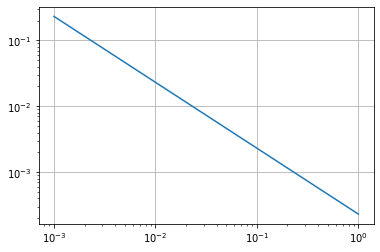

In [4]:
porosities = [(geom.periphery('hex', [x])*gapMelt/2)/(geom.area('hex', [x])) for x in diamsCrystal]
plt.loglog(diamsCrystal, porosities)
plt.grid()

In [5]:
mySheet = IceSheet.IceSheet(iceType='blackIce', thickness=100.0, crystalSize=100.0)

Ice type: blackIce


In [6]:
spatialNodeCount = 51
timeStepCount = 101

In [7]:
A, B, b, U0 = mySheet.setupModel(IC=[-1., 0.], windSpeed=5., aEnv=[0.15, 0.75, 0.1], TEnv=[-2.0, -20.0, -270.], S0=300., Nx=spatialNodeCount, Ny=timeStepCount)
A

array([[ 26.31919749, -25.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [-12.5       ,  26.        , -12.5       , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , -12.5       ,  26.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  26.        ,
        -12.5       ,   0.        ],
       [  0.        ,   0.        ,   0.        , ..., -12.5       ,
         26.        , -12.5       ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
        -12.5       ,  26.        ]])

In [8]:
Us = []
Us.append(U0)
U = U0

for idx in range(1, timeStepCount):
    U = np.linalg.solve(A, B.dot(U) + b)
    Us.append(U)
    
USoln = np.array(Us)

**TODO** Need to get dx, dy, zStep, tStep, zScale, tScale from mySheet

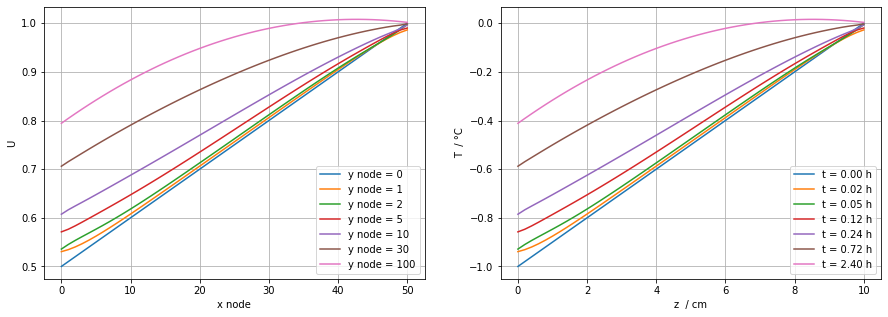

In [9]:
timeIndeces = np.array([0, 1, 2, 5, 10, 30, timeStepCount-1])

THi = 0.
TLo = -2.
TSoln = USoln*(THi - TLo) + TLo
z = np.linspace(0, spatialNodeCount, spatialNodeCount)*mySheet._h0/spatialNodeCount*100  # cm
t = np.linspace(0, timeStepCount, timeStepCount)*8770./timeStepCount/3660  # h

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for timeIndex in timeIndeces:
    i = 0
    axs[i].plot(range(spatialNodeCount), USoln[timeIndex, :], label='y node = '+'{}'.format(timeIndex))
    i = 1
    axs[i].plot(z, TSoln[timeIndex, :], label='t = '+'{:.2f} h'.format(t[timeIndex]))
i = 0
axs[i].set_xlabel('x node')
axs[i].set_ylabel('U')
i = 1
axs[i].set_xlabel('z  / cm')
axs[i].set_ylabel('T  / °C')
for i in range(2):
    axs[i].legend()
    axs[i].grid()

### Simulate a Day or Two

In [75]:
dateTimeStart = datetime.datetime(2021, 3, 21, 0, 0)
vnorm = np.array([0, 0, -1])  # plane pointing zenith
alt = 10  # m (above sea-level)
lat = 55.71  # Lund
# lat = 59.33  # Stockholm

totalTime = 48*3600  # s
timeStep = 15*60  # s
timeStepCount = totalTime//timeStep

spatialNodeCount = 51

In [94]:
mySheet = IceSheet.IceSheet(iceType='blackIce', thickness=200.0, crystalSize=100.0)
aEnv=[0.15, 0.75, 0.1]
TEnv=[-2.0, -20.0, -270.]

# get started
S0 = solarpy.irradiance_on_plane(vnorm, alt, dateTimeStart, lat)
A, B, b, U = mySheet.setupModel(IC=[-0.92, 0.], windSpeed=5., aEnv=aEnv, TEnv=TEnv, S0=S0, Nx=spatialNodeCount, Ny=timeStepCount, isVerbose=True)

# TODO: make a method of below
dateTime = dateTimeStart
time = 0

print(U[:2], U[-2:])

dateTimes = []
S0s = []
tSoln = []
USoln = []
for step in range(timeStepCount):
    dateTimes.append(dateTime)
    S0s.append(S0)
    tSoln.append(clockHour)
    
    # compute porosity epsilon(t)
#     meltRate = 
    
    USoln.append(U)

    time = (step + 1)*timeStep
    clockHour = (6 + time/3600) % 24
    dateTime = dateTimeStart + datetime.timedelta(seconds=+time)
    S0 = solarpy.irradiance_on_plane(vnorm, alt, dateTime, lat)
    mySheet.setSourceVector(S0)
    A, B, b = mySheet.applyBCs(aEnv, TEnv)
    U = np.linalg.solve(A, B.dot(U) + b)  # Note that the U on the right-hand side is the IC for this round's integration
    # output also: bIrradiance, porosity(z), ...
    
USoln = np.array(USoln)

Ice type: blackIce
thermal diffusivity a = 1.14e-06 m2/s
spatial stepsize dz = 4.00 mm
temporal stepsize dt = 183.66 s
timescale tScale = 35079.0 s
sigma = 6.544502617801047
[0.54   0.5492] [0.9908 1.    ]


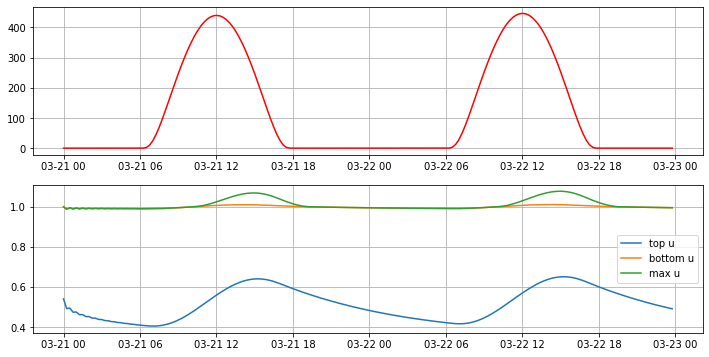

In [95]:
UMaxs = []
for j in range(len(USoln)):
    UMaxs.append(np.max(USoln[j, :]))

fig, axs = plt.subplots(2, 1, figsize=(12, 6))
i = 0
axs[i].plot(dateTimes, S0s, color='red', label='irradiance')
axs[i].grid()
i = 1
axs[i].plot(dateTimes, USoln[:, 0], label='top u')
axs[i].plot(dateTimes, USoln[:, -1], label='bottom u')
axs[i].plot(dateTimes, UMaxs, label='max u')
axs[i].grid()
axs[i].legend()

In [96]:
USoln.shape

(192, 51)

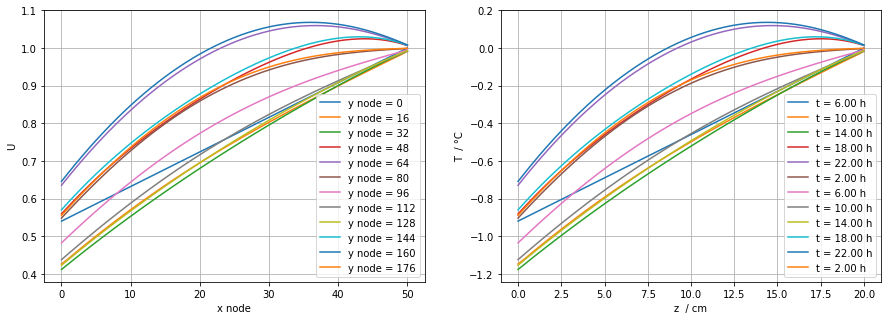

In [97]:
THi = 0.
TLo = -2.
TSoln = USoln*(THi - TLo) + TLo

z = np.linspace(0, spatialNodeCount, spatialNodeCount)*mySheet._h0/spatialNodeCount*100  # cm
t = np.linspace(0, timeStepCount, timeStepCount)*8770./timeStepCount/3660  # h

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for j in list(range(len(USoln)))[::16]:
    i = 0
    axs[i].plot(range(spatialNodeCount), USoln[j, :], label='y node = '+'{}'.format(j))
    i = 1
    axs[i].plot(z, TSoln[j, :], label='t = '+'{:.2f} h'.format(tSoln[j]))
i = 0
axs[i].set_xlabel('x node')
axs[i].set_ylabel('U')
i = 1
axs[i].set_xlabel('z  / cm')
axs[i].set_ylabel('T  / °C')
for i in range(2):
    axs[i].legend()
    axs[i].grid()